# 키워드 분석

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager,rc
import seaborn as sns
from plotnine import *
import matplotlib as mpl 
import matplotlib.font_manager as fm  
%matplotlib inline
#fbprophet 시계열 예측을 위한 라이브러리
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

#폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

!pip install -q 'plotnine[all]'
!pip show plotnine

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

font = fm.FontProperties(fname=path, size=9)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NanumBarunGothic
Name: plotnine
Version: 0.6.0
Summary: A grammar of graphics for python
Home-page: https://github.com/has2k1/plotnine
Author: None
Author-email: None
License: GPL-2
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, mizani, descartes, matplotlib, pandas, patsy, numpy, statsmodels
Required-by: 




In [128]:
#환자 정보 데이터

df1 = pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/datalab.xlsx')
df10 = pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/datalab2.xlsx')
df100 = pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/datalab3.xlsx')

gold = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/gold.csv')
oil = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/oil.csv')
over = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/over.csv')

recent_corona = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/corona.csv',encoding='euc-kr')
recent_corona.columns=['date','count']
recent_corona.date=pd.to_datetime(recent_corona.date)

In [129]:
df1=df1.iloc[6:,]
df1.columns=['date','코로나']
df1.reset_index(drop=True,inplace=True)

# print(df10)
df10=df10.iloc[6:,]
df10 = df10.drop([df10.columns[2],df10.columns[4]],axis=1)
df10.reset_index(drop=True,inplace=True)
df10.columns=['date','확진','마스크','사회적거리두기']
df10.date=pd.to_datetime(df10.date)


# print(df100.head)
df100=df100.iloc[6:,]
df100 = df100.drop([df100.columns[2],df100.columns[4]],axis=1)
df100.reset_index(drop=True,inplace=True)
df100.columns=['date','지역감염','집단감염','백신']
df100.date=pd.to_datetime(df100.date)


df1.date=pd.to_datetime(df1.date)
gold['date']=pd.to_datetime(gold['년/월/일'])
oil['date']=pd.to_datetime(oil['일자'])
over['start_date']=pd.to_datetime(over['지정일자'])
over['end_date']=pd.to_datetime(over['해제일자'])

gold = gold[['date','원/g 종가']]
gold=gold.rename(columns={'원/g 종가':'gold_price'})
oil = oil[['date','가중평균(협의)']]
oil=oil.rename(columns={'가중평균(협의)':'oil_price'})


In [130]:
df1=df1[df1.date.dt.year >= 2020].reset_index(drop=True) # 2019년 9월 이후의 데이터로 선택
gold=gold[gold.date.dt.year >= 2020].reset_index(drop=True) 
oil=oil[oil.date.dt.year >= 2020].reset_index(drop=True)
over=over[over.start_date.dt.year >= 2020].reset_index(drop=True)
recent_corona=recent_corona[recent_corona.date.dt.year >= 2020].reset_index(drop=True) 

df2=df1.merge(gold,on='date',how='inner')
df3=df2.merge(oil,on='date',how='inner')
df4=df3.merge(df10,on='date',how='inner')
df5=df4.merge(df100,on='date',how='inner')
final_data=df5.merge(recent_corona,on='date',how='inner')



In [131]:

final_data['코로나']= final_data['코로나'].astype('float')

final_data.gold_price=final_data.gold_price.str.replace(',','',regex=True)
final_data.gold_price= final_data.gold_price.astype('float')

final_data.oil_price=final_data.oil_price.str.replace(',','',regex=True)
final_data.oil_price= final_data.oil_price.astype('float')

final_data['확진']= final_data['확진'].astype('float')
final_data['마스크']= final_data['마스크'].astype('float')
final_data['집단감염']= final_data['집단감염'].astype('float')
final_data['사회적거리두기']= final_data['사회적거리두기'].astype('float')
final_data['지역감염']= final_data['지역감염'].astype('float')
final_data['집단감염']= final_data['집단감염'].astype('float')
final_data['백신']= final_data['백신'].astype('float')
final_data['count']= final_data['count'].astype('float')


In [132]:
final_data.describe()
final_data[final_data.oil_price == 0]
final_data= final_data.drop([82])
final_data.reset_index(drop=True,inplace=True)

In [143]:
final_data=final_data.rename(columns={'count' : '확진자 수'
                            })

In [144]:
final_data2=final_data.drop('date',axis=1)

final_data2.dtypes

코로나           float64
gold_price    float64
oil_price     float64
확진            float64
마스크           float64
사회적거리두기       float64
지역감염          float64
집단감염          float64
백신            float64
확진자 수         float64
dtype: object

                 코로나  gold_price  oil_price  ...      집단감염        백신     확진자 수
코로나         1.000000   -0.198188   0.262629  ...  0.219286  0.096478  0.649077
gold_price -0.198188    1.000000  -0.231628  ... -0.164716 -0.085930  0.086620
oil_price   0.262629   -0.231628   1.000000  ... -0.136553  0.140614  0.260447
확진          0.545331   -0.207770   0.369954  ... -0.036006  0.050419  0.299562
마스크         0.874425   -0.467334   0.423448  ...  0.054755  0.158892  0.472260
사회적거리두기     0.124907    0.226166   0.028604  ...  0.104161  0.002654  0.356506
지역감염        0.127784   -0.150205   0.094860  ... -0.028027 -0.052024 -0.081077
집단감염        0.219286   -0.164716  -0.136553  ...  1.000000  0.020718  0.185830
백신          0.096478   -0.085930   0.140614  ...  0.020718  1.000000  0.045970
확진자 수       0.649077    0.086620   0.260447  ...  0.185830  0.045970  1.000000

[10 rows x 10 columns]


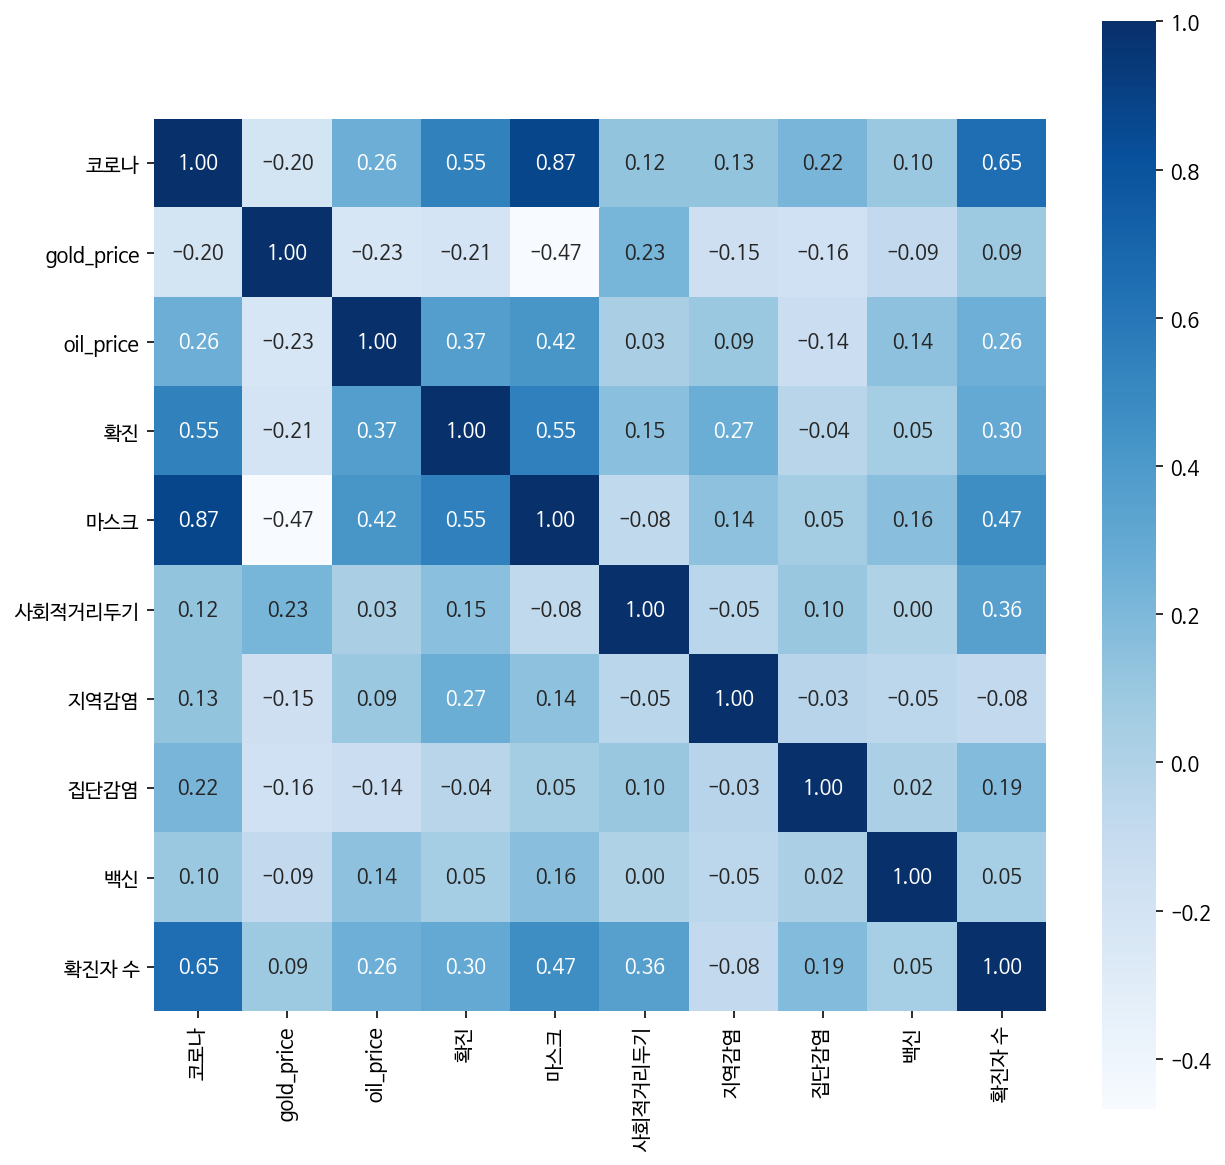

In [145]:
corr = final_data2.corr(method = 'pearson')
print(corr)
plt.figure(figsize=(10, 10))
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Blues')

In [146]:
scaler = StandardScaler()
X = scaler.fit_transform(final_data2)
X

array([[-0.85397174, -1.78201456,  1.36593951, ..., -0.85916497,
        -0.55057882, -0.71497898],
       [-0.74694707, -1.52826579,  1.33378365, ..., -0.80862251,
         0.07331878, -0.72359181],
       [-0.75602456, -1.61421296,  1.344253  , ..., -0.84653626,
         8.68541532, -0.72359181],
       ...,
       [ 0.36769178,  1.60062024,  0.21458295, ...,  0.04650006,
         0.09413511,  1.41239007],
       [ 0.20536996,  1.70498466,  0.23803702, ...,  0.03387135,
         0.06861383,  1.30042327],
       [ 0.14265214,  1.56992483,  0.23355015, ...,  0.28028997,
        -0.06554645,  1.57603384]])

In [147]:
X=pd.DataFrame(X)

X.columns = ['코로나','gold_price','oil_price','확진','마스크','사회적거리두기','지역감염','집단감염','백신','count']

X['date']= final_data['date']

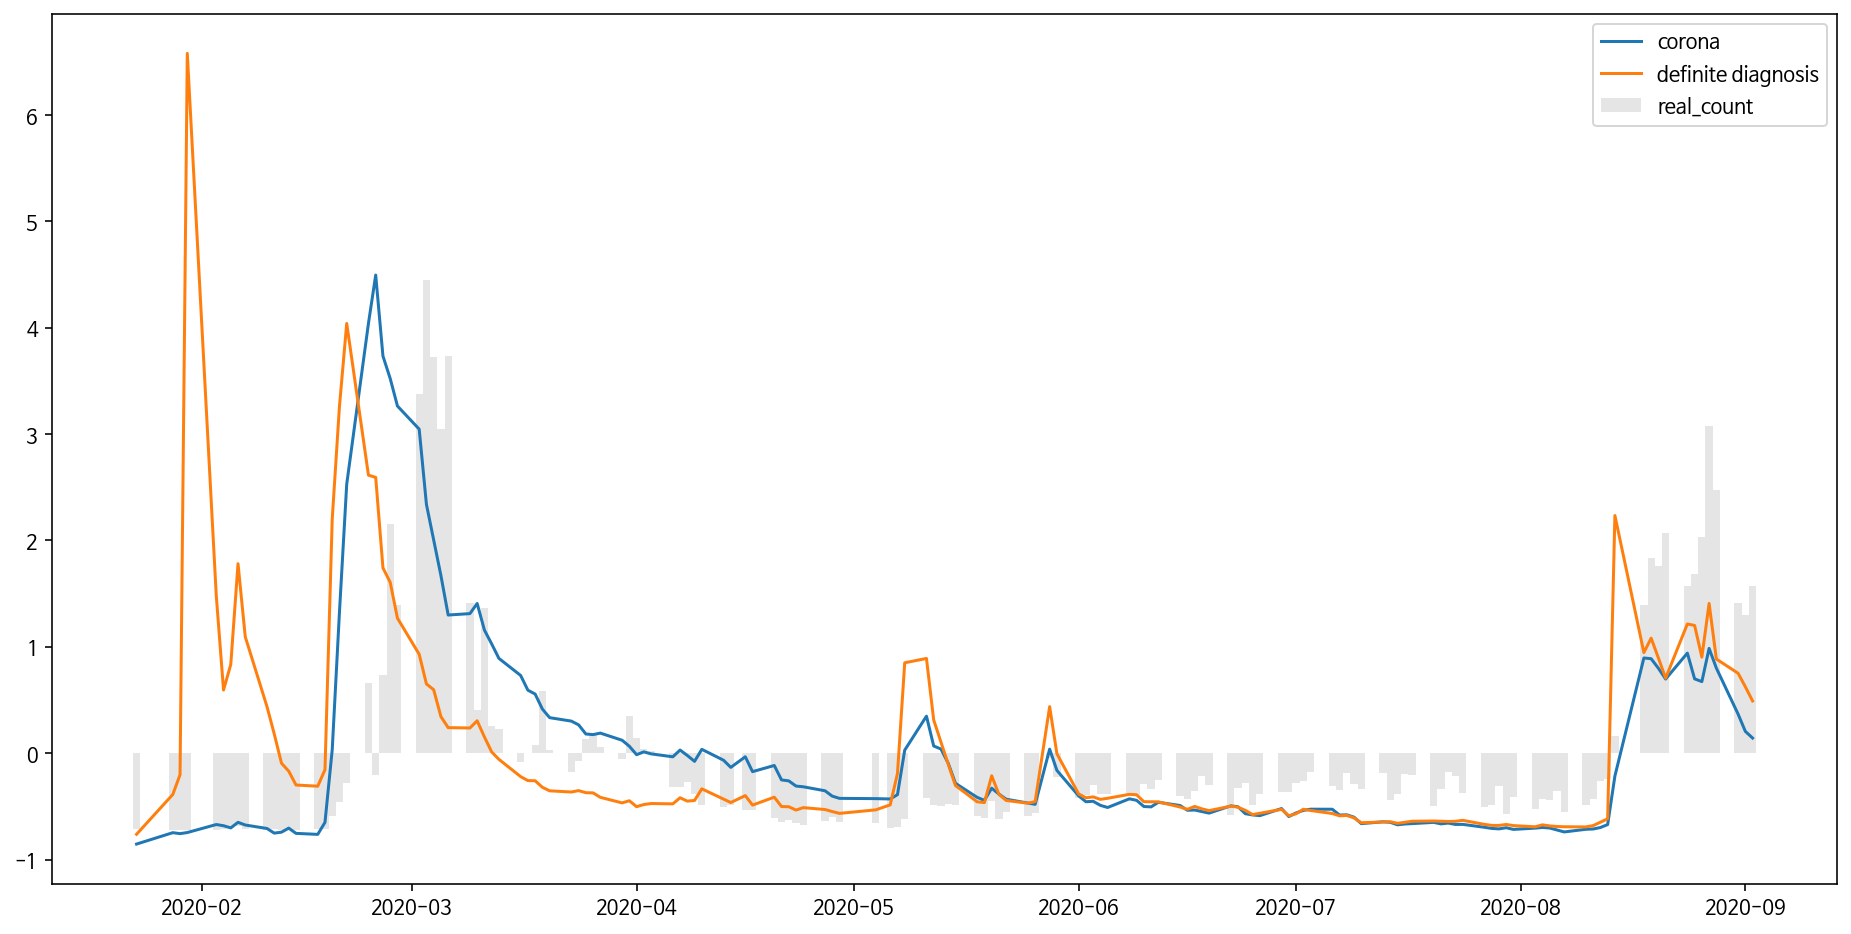

In [18]:
plt.figure(figsize=(16, 8)) # StandardScaler
# X.columns = ['코로나','gold_price','oil_price','확진','마스크','사회적거리두기','지역감염','집단감염','백신']
plt.bar(X.date,X['count'],label='real_count',color='gray',alpha=0.2,width=1)
plt.plot(X.date,X['코로나'],label='corona')
plt.plot(X.date,X['확진'],label='definite diagnosis') #코로나와 유사한 추세
# plt.plot(X.date,X['마스크'],label='mask') #마스크에 대한 수요 하락
# plt.plot(X.date,X['백신'],label='vaccine')

plt.legend()

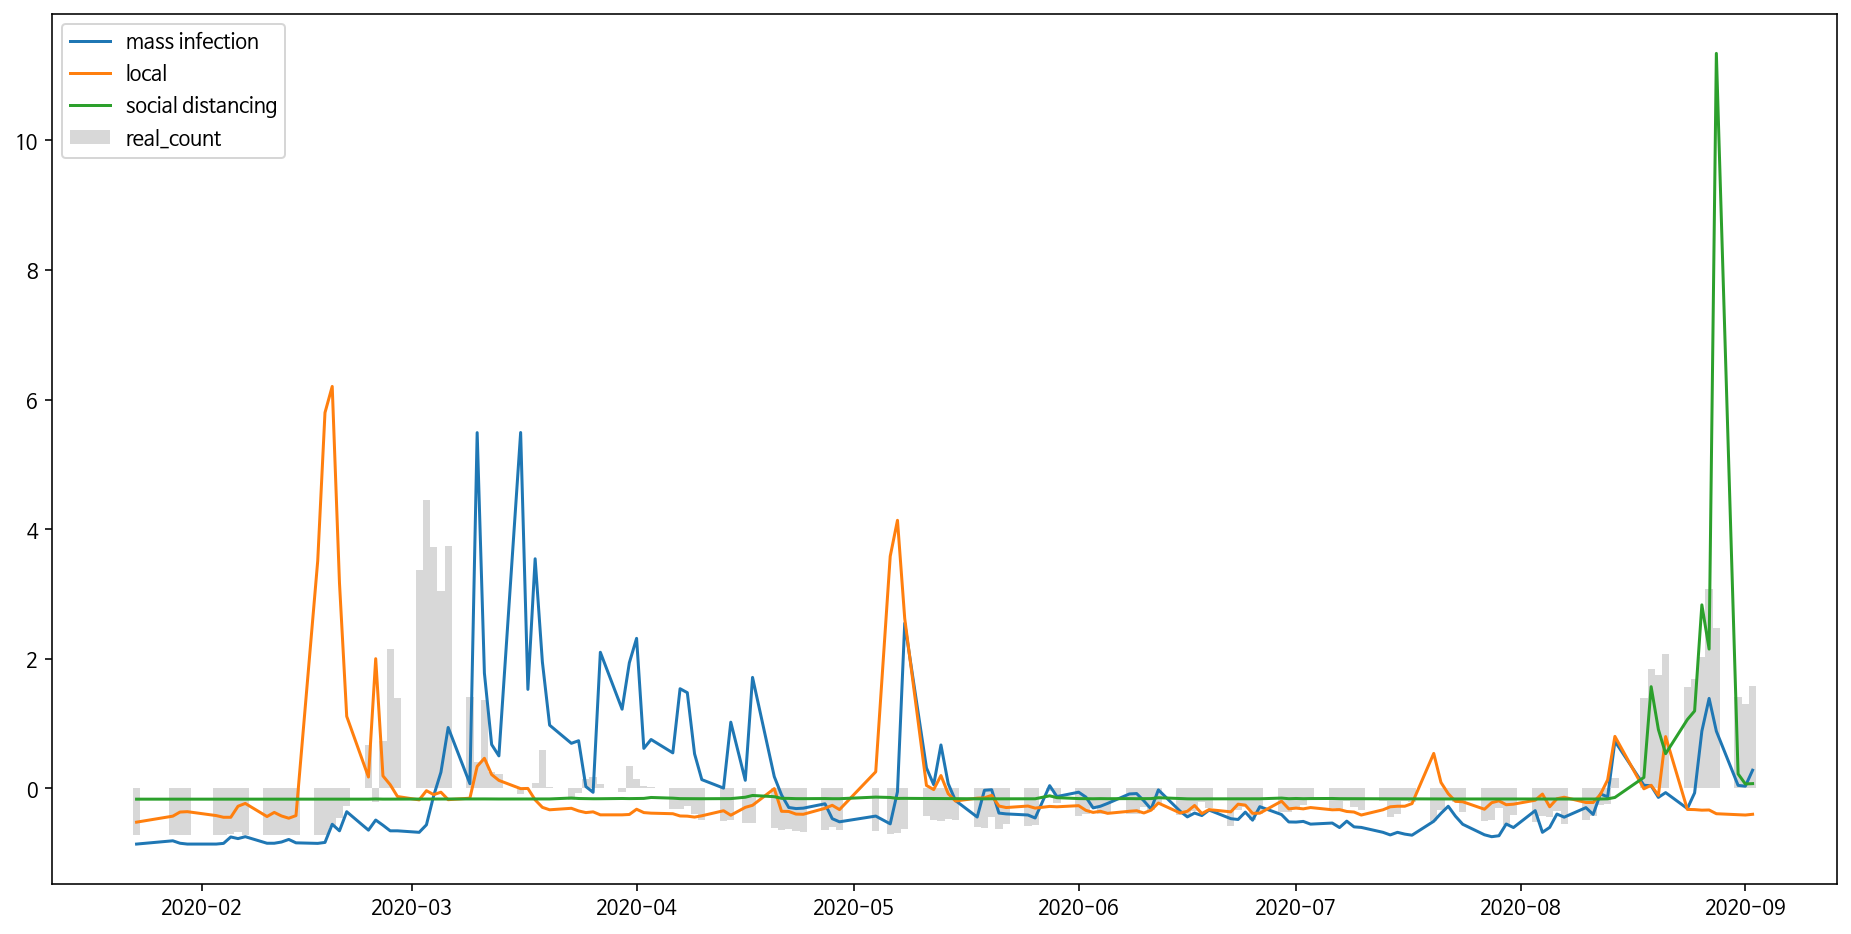

In [19]:
plt.figure(figsize=(16, 8)) #사회 현상 + stardard scaling

# X.columns = ['코로나','gold_price','oil_price','확진','마스크','사회적거리두기','지역감염','집단감염','백신']
plt.bar(X.date,X['count'],label='real_count',color='gray',alpha=0.3,width=1)
# plt.plot(X.date,X['코로나'],label='corona')
plt.plot(X.date,X['집단감염'],label='mass infection')
plt.plot(X.date,X['지역감염'],label='local')
plt.plot(X.date,X['사회적거리두기'],label='social distancing')

# plt.plot(X.date,X['코로나'],label='corona')


plt.legend()

In [20]:
card_data=pd.read_csv('/content/drive/My Drive/코로나/corona_git/dataset/KT_data_20200717/card_20200717.csv')

In [21]:
from datetime import datetime

# mrhst_induty_cl_nm는 업종을, recipt_dttm은 월을, salamt는 총 소비금액을 의미합니다.

card=card_data[['receipt_dttm','mrhst_induty_cl_nm','salamt']]
col = list(set(card['mrhst_induty_cl_nm']))
col.sort()

category = ['숙박업','숙박업','방송','홈쇼핑','연료','송금','상품권','패션','가전','가전','요식','건강','건강','건축','서비스',
'운송','잡화','스포츠','스포츠','스포츠','공공요금','공공요금','매점/편의점','설비','관광','교육','매점/편의점','자동차','자동차',
'패션','설비','관광','교육','교육','운송','가구','건강','건축','설비','운송','농업','서비스','스포츠','보험','유통',
'문구','문구','기타','숙박업','연료','서비스','유통','요식','의료','의류','자동차','잡화','기기','기타','주방','의류',
'회원제','회원제','회원제','회원제','회원제','의류','기기','유흥','농업','식품','식품','유흥','의류','스포츠','교육',
'대형할인점','교육','동물','스포츠','스포츠','렌트','의류','면세점','문구','문화','미용','식품','미용','예술','법률','법률','의료',
'보관창고','교육','인테리어','스포츠','부동산','부동산','비영리','농업','기타','비영리','사무','사무','사무','사무','개인',
'사우나','서비스','의료','상품권','상품권','보험','요식','문구','잡화','자동차','생활','컴퓨터','보험','스포츠','문화','자동차',
'대형마트','스포츠','식품','스포츠','스포츠','스포츠','패션','패션','잡화','의류','예술','패션','패션','마사지','동물','약국',
'잡화','운송','문구','문화','교육','의류','의류','문구','교육','면세점','방송','급식업','설비','연료','교육','교육','교육(해외)',
'유흥','설비','의료','의료','미용','통신','자동차','건강','인터넷쇼핑','인터넷쇼핑','인터넷쇼핑','인테리어','가구','문구',
'백화점','요식','요식','자동차','자동차','자동차','자동차','백화점','기타','장례','연료','문구','상우회','상품권(전자상)',
'상품권(전자상)','가전','식품','정기간행물','정보','의류','패션','식품','의료','가전','의료','조세','조세','스포츠','의료',
'용역','연료','자동차','주류','주방','주방','주점','자동차','자동차','요식','건축','운송','가구','교육','총포류','인쇄','의료',
'의료','생활','문화','자동차','카지노','주점','의류','컴퓨터','교육','숙박업','운송','운송','스포츠','통신','통신','통신','통신',
'통신','통신','통신','통신','숙박업','문화','인테리어','매점/편의점','미용','예술','교육','교육','의료','의료','의료','요식',
'항공','스포츠','혼례','혼례','건강','예술','문화','미용','유통','예술'
]

d= {} 
for i in range(260):
    d[col[i]] = category[i]


sales = card.groupby(['mrhst_induty_cl_nm','receipt_dttm']).sum()['salamt'].reset_index()
sales.mrhst_induty_cl_nm = sales.mrhst_induty_cl_nm.replace(d)
sales.receipt_dttm = [datetime.strptime(str(x),'%Y%m%d').month for x in sales.receipt_dttm]
sales = sales.groupby(['mrhst_induty_cl_nm','receipt_dttm']).sum()['salamt'].reset_index()
sales = sales[sales.receipt_dttm !=6]
remove = ['공공요금','개인','기타','비영리','상우회','정보','회원제','총포류','카지노','송금','조세','농업','설비']
sales = sales[~sales.mrhst_induty_cl_nm.isin(remove)]


In [108]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 419
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mrhst_induty_cl_nm  300 non-null    object
 1   receipt_dttm        300 non-null    int64 
 2   salamt              300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.4+ KB


In [115]:


top20 = sales.pivot_table(values='salamt',index='mrhst_induty_cl_nm').reset_index().sort_values('salamt',ascending=False).head(20)
top20.reset_index(drop=True, inplace=True)
top20['salamt'] = top20['salamt']
top20=top20.sort_values('salamt',ascending=True)

In [119]:
bottom20 = sales.pivot_table(values='salamt',index='mrhst_induty_cl_nm').reset_index().sort_values('salamt',ascending=True).head(20)
bottom20.reset_index(drop=True, inplace=True)
bottom20=bottom20.sort_values('salamt',ascending=False)

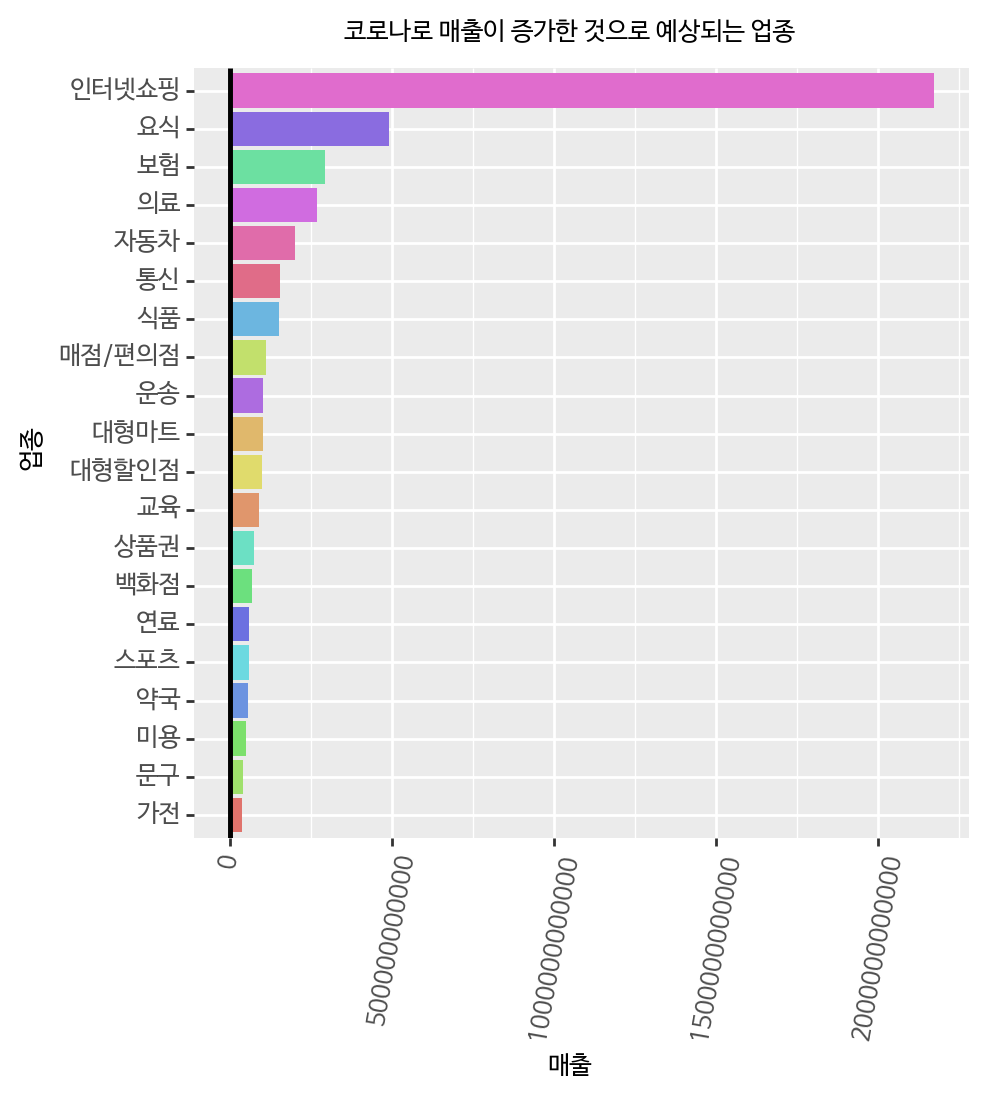

<ggplot: (8750648716927)>

In [158]:
(ggplot(data=top20,mapping=aes(x='mrhst_induty_cl_nm',y='salamt'))
+geom_bar(stat='identity',mapping =aes(fill='mrhst_induty_cl_nm'),show_legend=False)
+theme(figure_size=(5,5),axis_text_x=element_text(size=13,angle=80))
+geom_hline(yintercept=0,size=1)
+ggtitle('코로나로 매출이 증가한 것으로 예상되는 업종')
+scale_fill_hue(l=0.65)
+ theme(text=element_text(fontproperties=font))
+ coord_flip()
+xlab("업종") + ylab("매출")
+ scale_x_discrete(limits = top20.mrhst_induty_cl_nm))

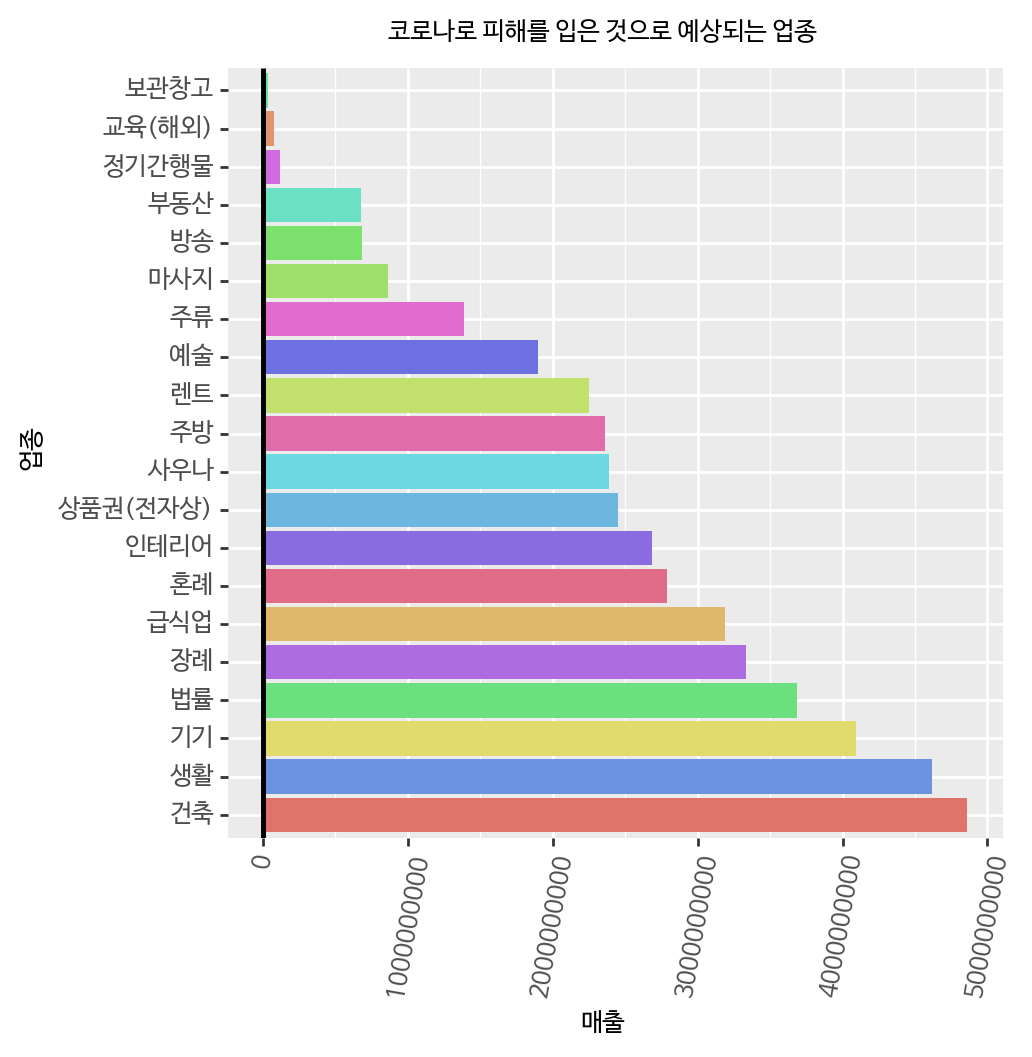

<ggplot: (-9223363286202828456)>

In [120]:
(ggplot(data=bottom20,mapping=aes(x='mrhst_induty_cl_nm',y='salamt'))
+geom_bar(stat='identity',mapping =aes(fill='mrhst_induty_cl_nm'),show_legend=False)
+theme(figure_size=(5,5),axis_text_x=element_text(size=13,angle=80))
+geom_hline(yintercept=0,size=1)
+ggtitle('코로나로 피해를 입은 것으로 예상되는 업종')
+scale_fill_hue(l=0.65)
+ theme(text=element_text(fontproperties=font))
+ coord_flip()
+xlab("업종") + ylab("매출") 
+ scale_x_discrete(limits = bottom20.mrhst_induty_cl_nm))


# 사회적 거리두기 시행

In [25]:
subway20=pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/seoul_data/서울교통공사_1_8호선일별역별시간대별승하차인원_202001_202005.csv',encoding='euc-kr')

subway19=pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/seoul_data/2019년 1월_12월 역별 시간대별 승하차인원.xlsx',header=1)

In [26]:
subway19_select=subway19[['날짜','호선','역번호','역명','24시 이후','합 계']]
subway20_select=subway20[['날짜','호선','역번호','역명','24시 이후','합 계']]

subway19_select['날짜']=pd.to_datetime(subway19_select['날짜'])
subway20_select['날짜']=pd.to_datetime(subway20_select['날짜'])

subway19_select.head()
subway19_select.info()

subway20_select.head()
subway20_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200804 entries, 0 to 200803
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   날짜      200804 non-null  datetime64[ns]
 1   호선      200804 non-null  object        
 2   역번호     200804 non-null  int64         
 3   역명      200804 non-null  object        
 4   24시 이후  200804 non-null  int64         
 5   합 계     200804 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83756 entries, 0 to 83755
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      83756 non-null  datetime64[ns]
 1   호선      83756 non-null  object        
 2   역번호     83756 non-null  int64         
 3   역명      83756 non-null  object        
 4   24시 이후  83756 non-null  int64         
 5   합 계     83756 non-null  int64         
d

In [27]:
subway20_total=pd.pivot_table(subway20_select, index='날짜',values='합 계',aggfunc=np.sum)
subway20_total.reset_index(inplace=True)
subway19_total=pd.pivot_table(subway19_select, index='날짜',values='합 계',aggfunc=np.sum)
subway19_total.reset_index(inplace=True)

subway20_total.columns=['date','subway_count']
subway19_total.columns=['date','subway_count']




In [28]:
total=pd.concat([subway19_total, subway20_total])
total_sub=total[(total['date'] >= '2019-09-01')]
total_sub.reset_index(drop=True,inplace=True)
total_sub

,date,subway_count
0,2019-09-01,6073293
1,2019-09-02,10779181
2,2019-09-03,10987394
3,2019-09-04,10711376
4,2019-09-05,10651151
...,...,...
269,2020-05-27,8697672
270,2020-05-28,8544380
271,2020-05-29,8751344
272,2020-05-30,5504463


# 1월부터 9월까지 확진자 추세

# 지하철 이용량 - 사회적 거리두기는 잘 이루어지고 있을까?

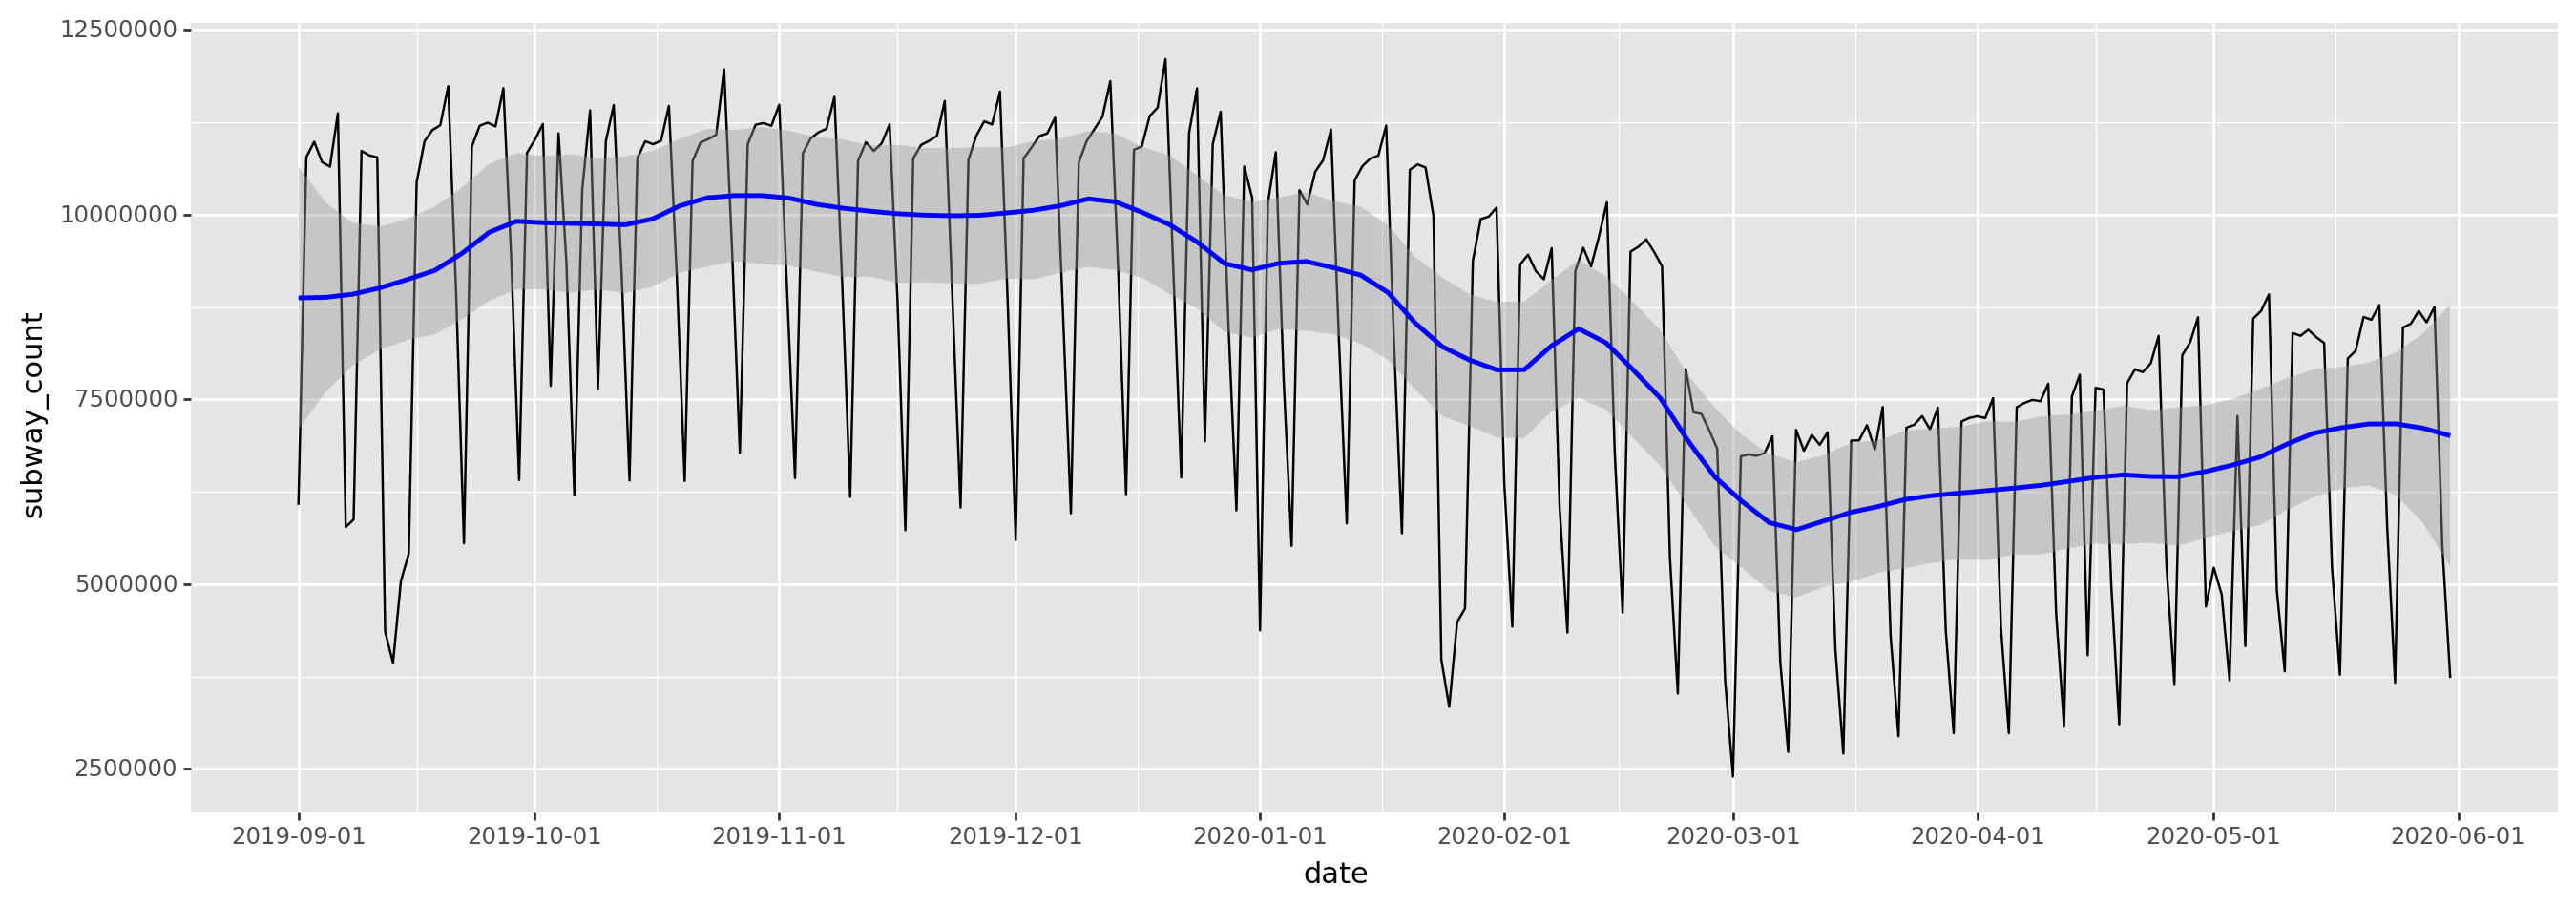

<ggplot: (-9223363286198345507)>

In [29]:
p = (ggplot(aes(x='date', y='subway_count'), data=total_sub) +\
    geom_line() +\
    stat_smooth(colour='blue', span=0.2))

p + theme(
    panel_background=element_rect(fill='gray', alpha=.2),
    #dpi=120,
    figure_size=(16, 8), # inches
    aspect_ratio=1/3    # height:width
)


# 광화문집회 확산 양상


In [30]:
import pandas as pd
import numpy as np
import datetime
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [31]:
test = recent_corona[recent_corona.date > '2020-08-15'].reset_index(drop=True)
train = recent_corona[recent_corona.date <= '2020-08-15'].reset_index(drop=True)

In [32]:
distance_prophet = train.rename(columns={'date': 'ds','count': 'y'})
distance_prophet.head()
m=Prophet()
m.fit(distance_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


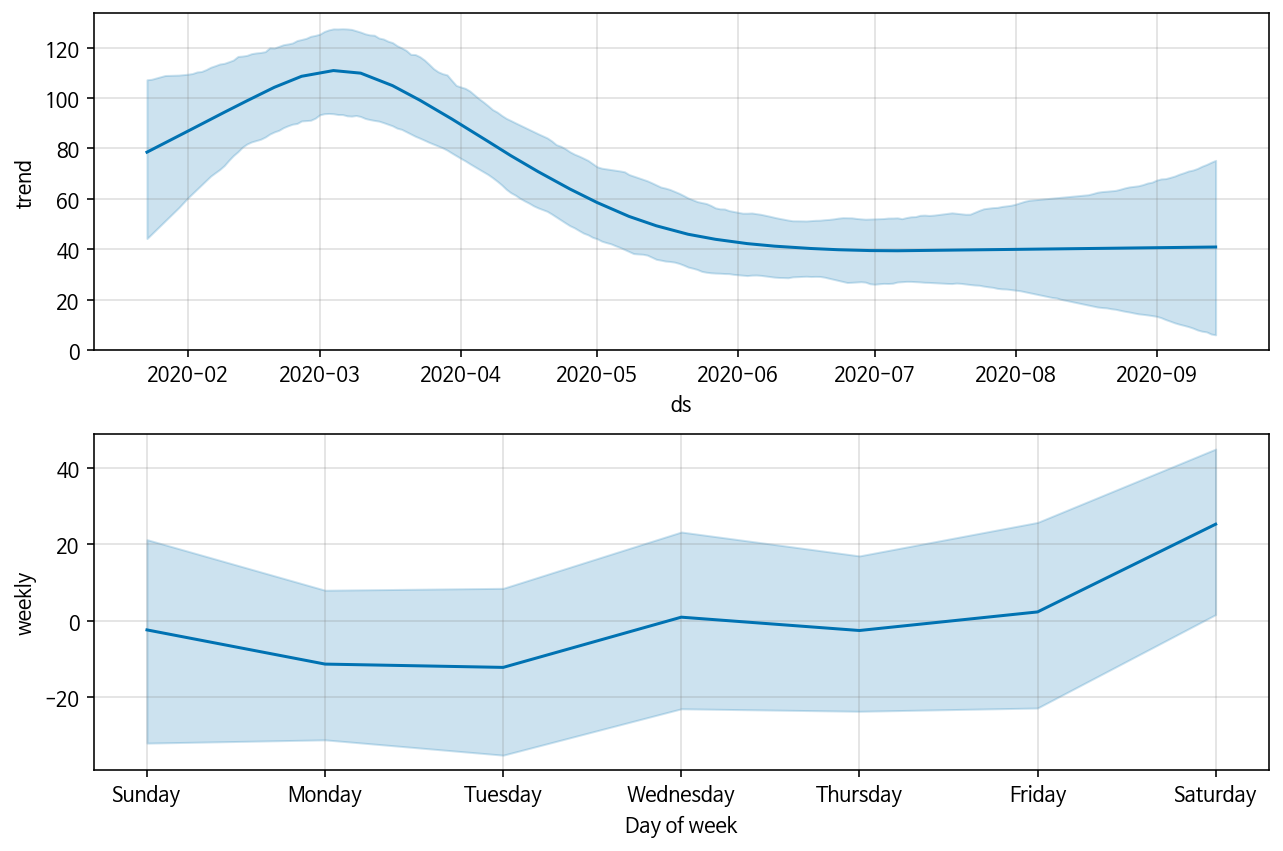

In [33]:
#예측할 미래 dataframe 만들기
future=m.make_future_dataframe(periods=30)

#불확실성의 범위 보기
forecast = Prophet(interval_width=0.95).fit(distance_prophet).predict(future)
#시즈널리티의 불확실성을 알기 위해 베이지안 샘플링을 사용해야 함,mcmc.samples 파라미터를 사용. 이 값을 사용하면 최초 n일에 대해 적용한다는 뜻
m = Prophet(mcmc_samples=62)
forecast = m.fit(distance_prophet).predict(future)
fig = m.plot_components(forecast)

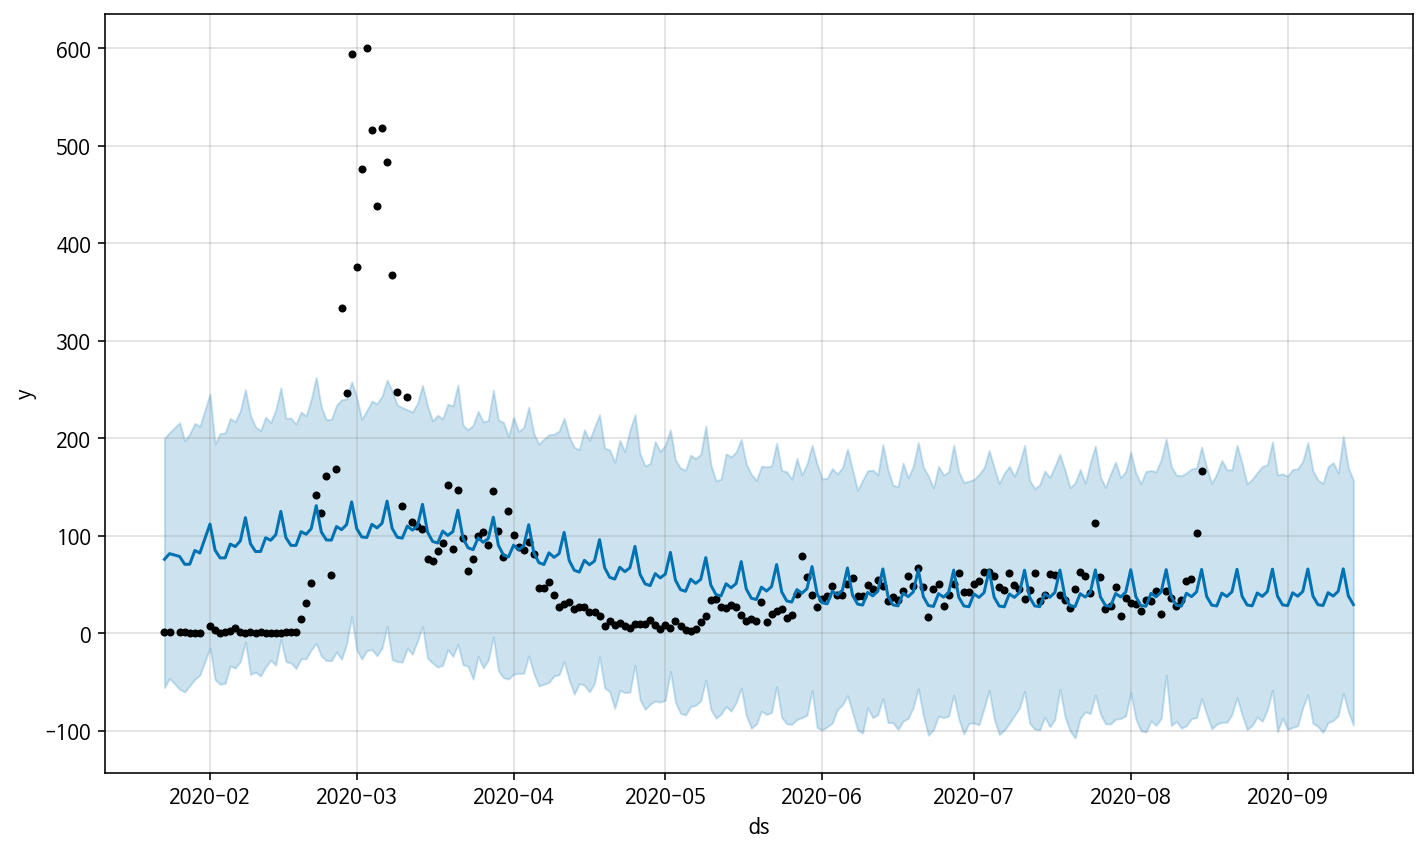

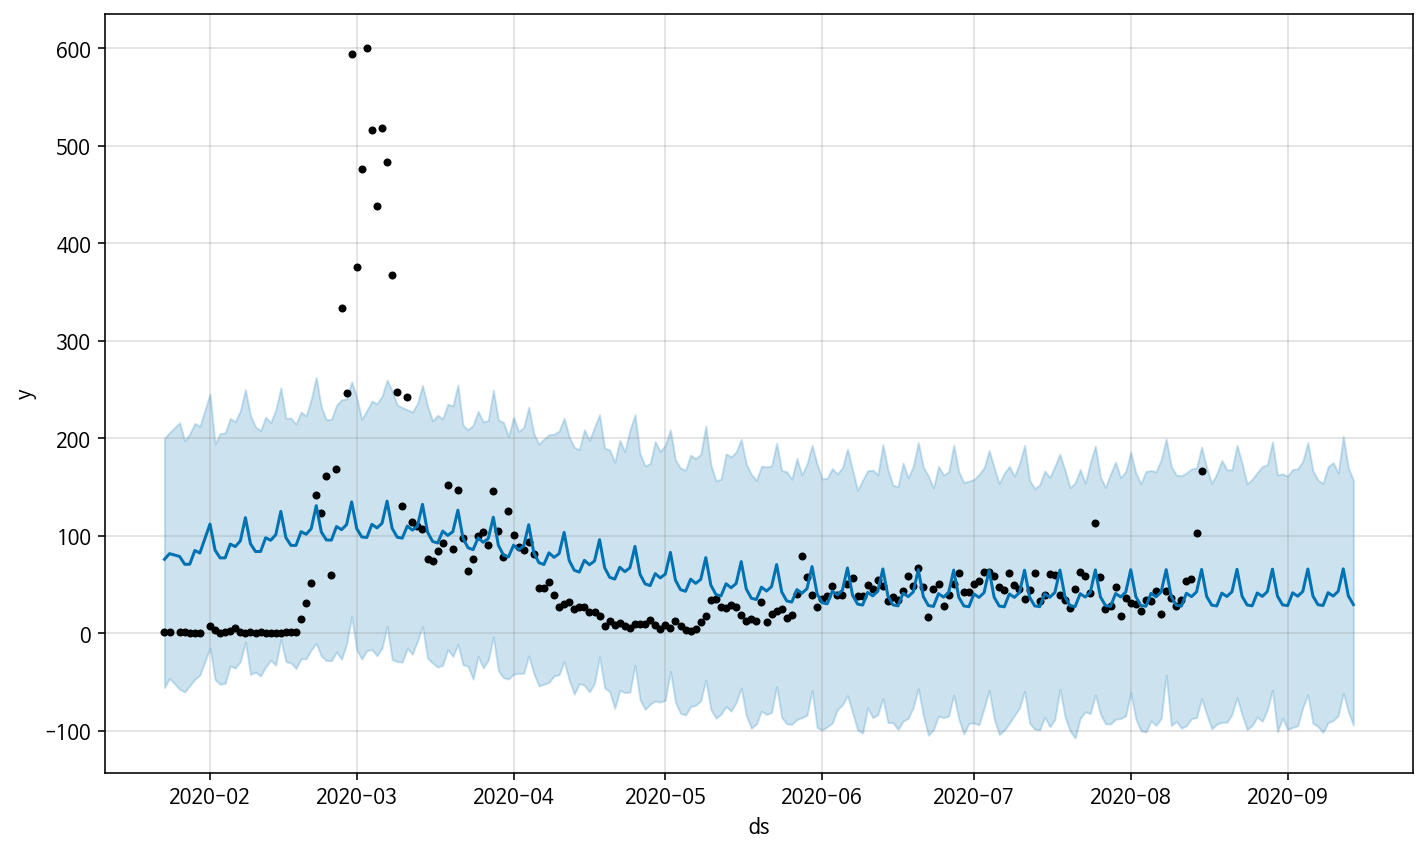

In [34]:
m.plot(forecast)

In [35]:
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible 디폴트는 0.05
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    
)

m.fit(distance_prophet)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


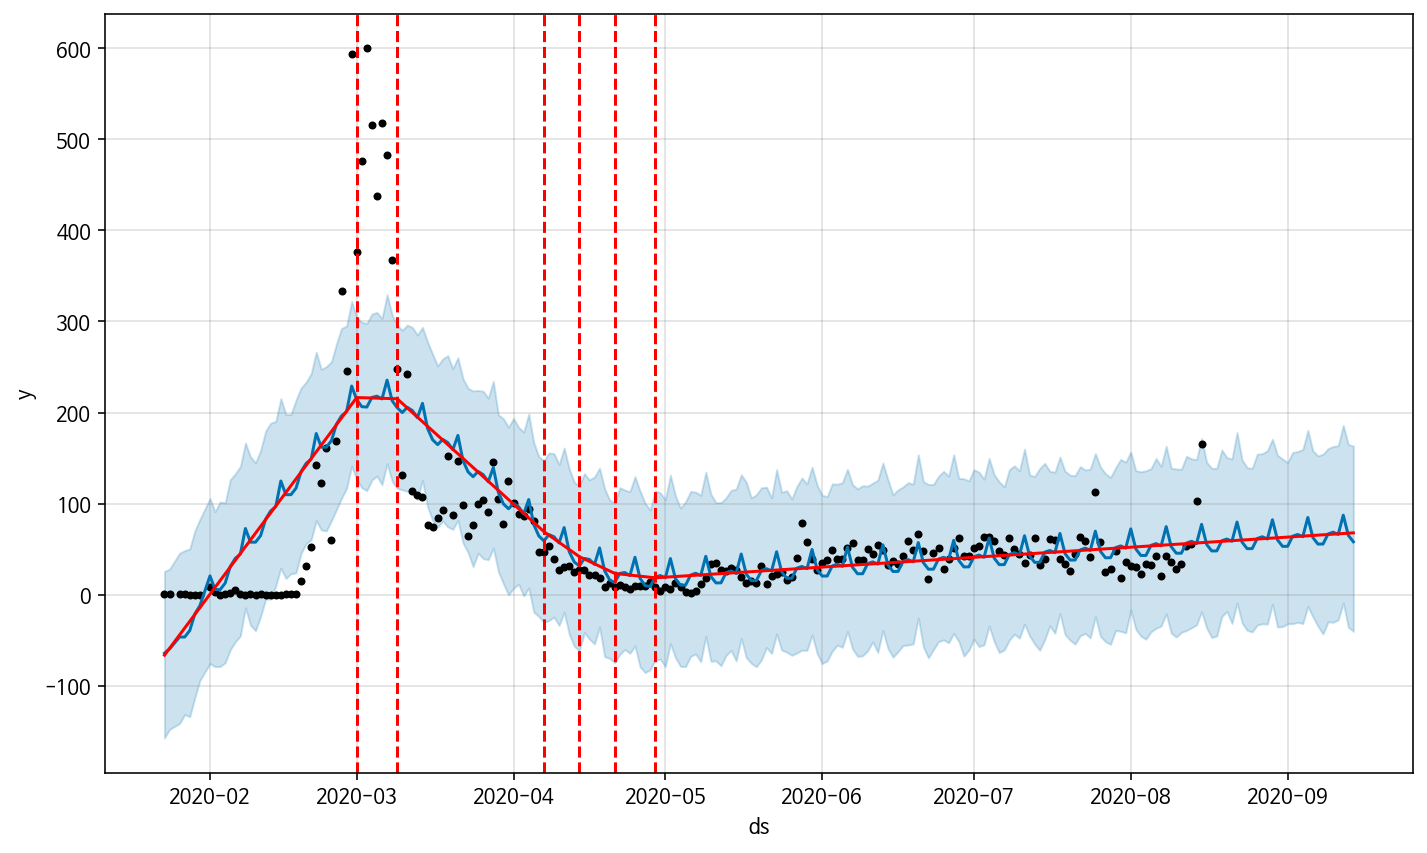

In [36]:
fig = m.plot(forecast)#파란선

a = add_changepoints_to_plot(fig.gca(), m, forecast)#빨간 선 나타내기

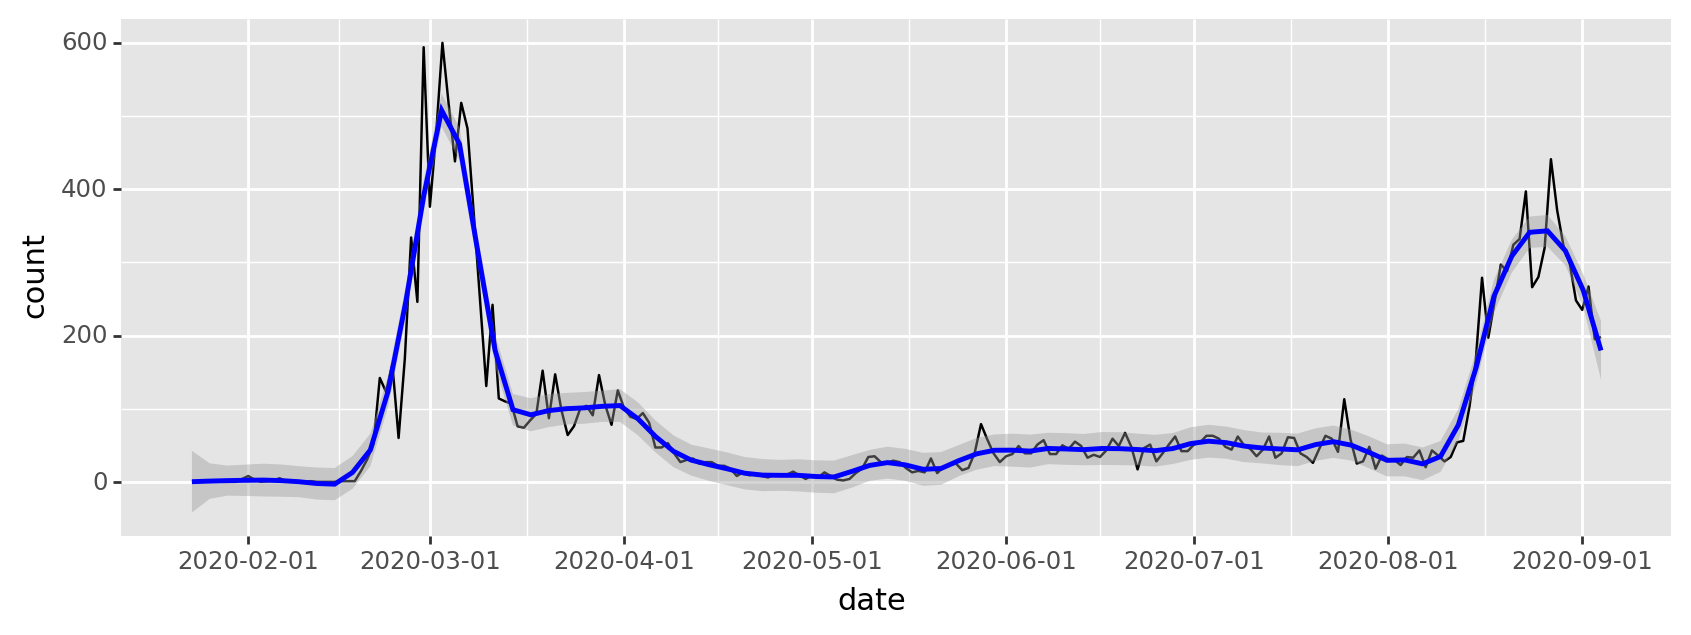

<ggplot: (8750656126363)>

In [37]:
p = (ggplot(aes(x='date', y='count'), data=recent_corona) +\
    geom_line() +\
    stat_smooth(colour='blue', span=0.1))

p + theme(
    panel_background=element_rect(fill='gray', alpha=.2),
    #dpi=120,
    figure_size=(10, 8), # inches
    aspect_ratio=1/3    # height:width
)